In [5]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

np.random.seed(42)


In [7]:
#load data
df = pd.read_csv("../cyberbullying_tweets.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}") # two coloumns
print(df.head())

Dataset shape: (47692, 2)

Columns: ['tweet_text', 'cyberbullying_type']
                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


In [8]:
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Class distribution:\n{df['cyberbullying_type'].value_counts()}")
print(f"Number of unique classes: {df['cyberbullying_type'].nunique()}")

Missing values:
tweet_text            0
cyberbullying_type    0
dtype: int64
Class distribution:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64
Number of unique classes: 6


In [9]:
def _remove_emojis(s):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F]"
        "|[\U0001F300-\U0001F5FF]"
        "|[\U0001F680-\U0001F6FF]"
        "|[\U0001F1E0-\U0001F1FF]"
        "|[\U00002700-\U000027BF]"
        "|[\U0001F900-\U0001F9FF]"
        "|[\U00002600-\U000026FF]",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(" ", s)


def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = text.replace("#", "")
    text = _remove_emojis(text)
    text = re.sub(r"_+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

df['processed_text'] = df['tweet_text'].apply(preprocess_text)

In [10]:
X = df['processed_text']
y = df['cyberbullying_type']

#here we are splitting up the train n test sets 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 38153
Test set size: 9539


In [11]:
#now we must turn each tweet into a vector(since the algo cannot use works directly)
#we look at the word and the character level very easy to break understnading if misspledd 
word_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=2
)

X_train_word = word_vectorizer.fit_transform(X_train)
X_train_char = char_vectorizer.fit_transform(X_train)

X_test_word = word_vectorizer.transform(X_test)
X_test_char = char_vectorizer.transform(X_test)

X_train_tfidf = hstack([X_train_word, X_train_char])
X_test_tfidf = hstack([X_test_word, X_test_char])

print(f"Word features (train): {X_train_word.shape}")
print(f"Char features (train): {X_train_char.shape}")
print(f"Combined features (train): {X_train_tfidf.shape}")

Word features (train): (38153, 20000)
Char features (train): (38153, 245379)
Combined features (train): (38153, 265379)


In [14]:
# Train model for multi class classification
log_reg = LogisticRegression(
    max_iter=2000,
    solver='lbfgs'
)

log_reg.fit(X_train_tfidf, y_train)

# Predict
y_pred = log_reg.predict(X_test_tfidf)
y_proba = log_reg.predict_proba(X_test_tfidf)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.8318482021176223
Log Loss: 0.41496640990210615
                     precision    recall  f1-score   support

                age       0.98      0.98      0.98      1598
          ethnicity       0.98      0.97      0.98      1592
             gender       0.91      0.85      0.88      1595
  not_cyberbullying       0.59      0.58      0.58      1589
other_cyberbullying       0.59      0.65      0.62      1565
           religion       0.96      0.95      0.96      1600

           accuracy                           0.83      9539
          macro avg       0.83      0.83      0.83      9539
       weighted avg       0.84      0.83      0.83      9539



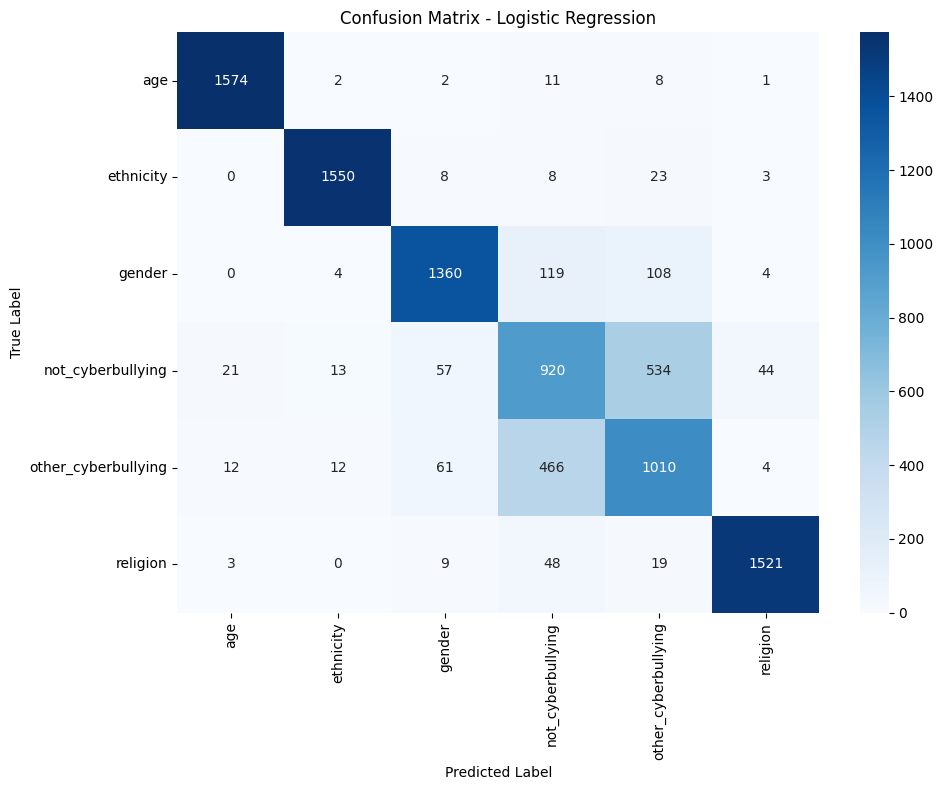

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=log_reg.classes_,
            yticklabels=log_reg.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()